# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


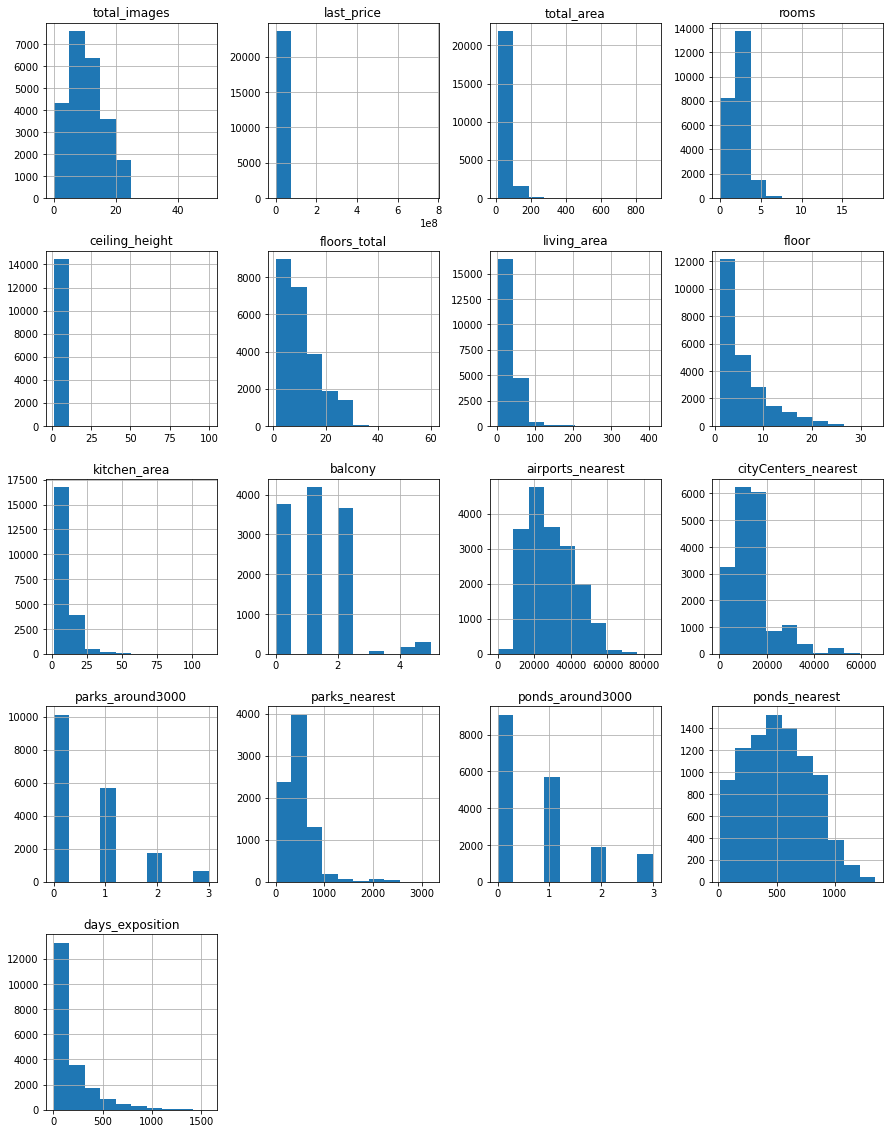

In [1]:
import pandas as pd
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
df.info()

pd.set_option('display.max_columns', 50)
display(df.head(5))

df.hist(figsize=(15, 20))
print(" ")

### Предобработка данных

#### Найдите и изучите пропущенные значения в столбцах:

In [2]:
data = df.copy(deep=True) # создадим копию датафрейма
data.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [3]:
data['is_apartment'] = data['is_apartment'].fillna(False) 
# если продавец не указал, является ли недвижимость апартаментами, то, скорее всего, ответ "Нет"

In [4]:
data['balcony'] = data['balcony'].fillna(0)
# если продавец не указал число балконов, то, скорее всего, в его квартире их нет
data['parks_around3000'] = data['parks_around3000'].fillna(0)
# если продавец не указал число парков рядом (3 км), то, скорее всего, их нет
data['ponds_around3000'] = data['ponds_around3000'].fillna(0) 
# если продавец не указал число прудов рядом (3 км), то, скорее всего, их нет

<AxesSubplot:>

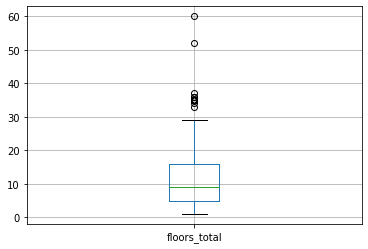

In [5]:
data.boxplot(column='floors_total')

In [6]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [7]:
data['floors_total'].isna().sum()

86

In [8]:
pd.set_option('display.max_rows',100)
display(data.query('floors_total.isna() == True'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.20,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,False,False,False,12.00,0.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.10,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,False,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.80,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,False,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.60,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,False,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.00,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
1930,1,9750000.0,66.77,2016-05-13T00:00:00,2,NaN,NaN,NaN,4,False,False,False,NaN,0.0,Санкт-Петербург,39886.0,10660.0,1.0,2276.0,3.0,244.0,90.0
2392,7,5395770.0,53.00,2017-06-29T00:00:00,2,NaN,NaN,29.00,22,False,False,False,9.00,0.0,Санкт-Петербург,43074.0,10820.0,0.0,NaN,0.0,NaN,48.0
2846,4,2325000.0,27.80,2016-09-21T00:00:00,1,NaN,NaN,19.40,15,False,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,307.0
2952,10,6500000.0,54.30,2019-04-23T00:00:00,1,NaN,NaN,22.20,6,False,False,False,12.30,0.0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
3031,9,6400000.0,56.70,2018-03-27T00:00:00,2,NaN,NaN,32.00,12,False,False,False,12.00,0.0,Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,231.0


In [9]:
data.isna().sum().sort_values(ascending=False)                            

parks_nearest           15620
ponds_nearest           14589
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
balcony                     0
ponds_around3000            0
parks_around3000            0
total_images                0
last_price                  0
studio                      0
is_apartment                0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

> Заполнены пропуски в:
* is_apartment (значением False)
* balcony (на 0)
* parks_around3000 (на 0)
* ponds_around3000 (на 0)
* floors_total (на медианное значение)
* days_exposition (на медианное значение)

> Не заполняю пропуски в: 
* parks_nearest 
* ponds_nearest
* airports_nearest         
* cityCenters_nearest
* locality_name <br/>
(эта информация не является критически важной)

> На следующих этапах после фильтрации заполню медианным значением:
* ceiling_height
* kitchen_area
* living_area

> Причины, которые могли привести к пропускам в данных:

* ошибки ввода данных
* сокрытие информации
* фрод

#### Рассмотрите типы данных в каждом столбце:

In [10]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [11]:
data.isna().sum().sort_values(ascending=False)  

parks_nearest           15620
ponds_nearest           14589
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
balcony                     0
ponds_around3000            0
parks_around3000            0
total_images                0
last_price                  0
studio                      0
is_apartment                0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [12]:
data = data.dropna(subset=['floors_total']) # убрала строки таблицы, где в столбце floors_total пропущено значение

In [13]:
info_lost_drop_floors_total_null = (df['total_images'].count() - data['total_images'].count())/df['total_images'].count() * 100
# использую подсчет квартир по солбцу total_images, т.к. там не было пропусков

print(f"Потеря информации за счет удаления квартир " \
        f"где не указано число этажей в доме {info_lost_drop_floors_total_null:.2f}%")

Потеря информации за счет удаления квартир где не указано число этажей в доме 0.36%


In [14]:
data.isna().sum().sort_values(ascending=False)  

parks_nearest           15568
ponds_nearest           14552
ceiling_height           9118
airports_nearest         5532
cityCenters_nearest      5509
days_exposition          3172
kitchen_area             2231
living_area              1870
locality_name              48
ponds_around3000            0
parks_around3000            0
balcony                     0
total_images                0
last_price                  0
studio                      0
is_apartment                0
floor                       0
floors_total                0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [15]:
data['floors_total'] = data['floors_total'].astype('int') #был float64, но количество этажей - целое число
data['balcony'] = data['balcony'].astype('int') #был float64, но количество балконов - целое число   
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [16]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

> Изменила тип данных в колонках:
*  first_day_exposition (на datetime)
*  floors_total (на int)
*  balcony

> Когда речь идёт об исследовании наборов данных, размеры которых могут достигать нескольких гигабайт, проблемы  <br/>
с производительностью могут приводить к значительному увеличению длительности анализа данных и могут становиться  <br/>
причиной невозможности проведения анализа из-за нехватки памяти. <br/>
<br/>
Выбор корректного типа данных позволяет снизить потребление памяти и увеличить скорость обработки. Более того, если тип данных определен неверно, это может помешать расчетам (числовые значения определены как строки object)

#### Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты:

In [17]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [18]:
# Рассмотрим уникальные названия в колонке locality_name
data['locality_name'].unique()
len(data['locality_name'].unique())

365

In [19]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')

In [20]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Федоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

In [21]:
len(data['locality_name'].unique())
# Убрали все неявные дубликаты

323

#### Найдите и устраните редкие и выбивающиеся значения:

In [22]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

<AxesSubplot:>

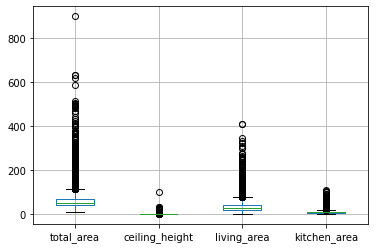

In [23]:
import matplotlib.pyplot as plt
data.boxplot(column=['total_area', 'ceiling_height', 'living_area', 'kitchen_area'])

'total_area', 'ceiling_height', 'living_area', 'kitchen_area'

count    14495.000000
mean         2.771495
std          1.261445
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

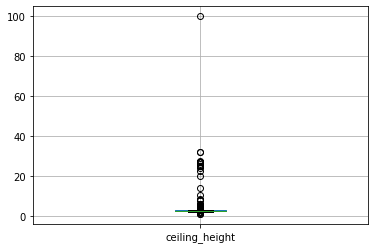

In [24]:
data.boxplot(column='ceiling_height')
data['ceiling_height'].describe()

In [25]:
data['ceiling_height'] = data['ceiling_height'].where((data['ceiling_height']<10.3), (data['ceiling_height']/10))

print(data['ceiling_height'].unique())

[ 2.7    nan  3.03  2.5   2.67  2.56  3.05  2.75  2.6   2.9   2.8   2.55
  3.    2.65  3.2   2.61  3.25  3.45  2.77  2.85  2.64  2.57  4.15  3.5
  3.3   2.71  4.    2.47  2.73  2.84  3.1   2.34  3.4   3.06  2.72  2.54
  2.51  2.78  2.76  2.58  3.7   2.52  5.2   2.87  2.66  2.59  2.    2.45
  3.6   2.92  3.11  3.13  3.8   3.15  3.55  3.16  3.62  3.12  2.53  2.74
  2.96  2.46  5.3   5.    2.79  2.95  4.06  2.94  3.82  3.54  3.53  2.83
  4.7   2.4   3.38  3.01  5.6   3.65  3.9   3.18  3.35  2.3   3.57  2.48
  2.62  2.82  3.98  2.63  3.83  3.52  3.95  3.75  2.88  3.67  3.87  3.66
  3.85  3.86  4.19  3.24  4.8   4.5   4.2   3.36  3.08  3.68  3.07  3.37
  3.09  8.    3.26  3.34  2.81  3.44  2.97  3.14  4.37  2.68  3.22  3.27
  4.1   2.93  3.46  3.47  3.33  3.63  3.32  1.2   8.3   2.98  2.86  3.17
  4.4   3.28  3.04  4.45  5.5   3.84  3.23  3.02  3.21  3.43  3.78  4.3
  3.39  2.69  3.31  4.65  3.56  2.2   3.51  3.93  3.42  2.99  3.49  1.4
  4.14  2.91  3.88  1.75  4.25  3.29  2.25  3.76  3.69

<AxesSubplot:>

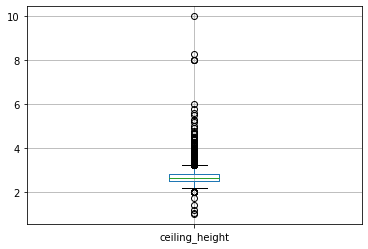

In [26]:
data.boxplot(column='ceiling_height')

In [27]:
# Высота потолка жилого помещения не может быть ниже 2,4 м (норма в России), верхняя граница может достигать 10 м, 
# однако это редкое значение, поэтому верхняя граница по высоте будет 6 м
data_ceiling_height = data.query('(ceiling_height > 2.4) and (ceiling_height < 6)')

# Заменяем пропуски в столбце 'ceiling_height'  на медианное значение
data['ceiling_height'] = data['ceiling_height'].fillna(data_ceiling_height['ceiling_height'].median())

In [28]:
info_lost_ceiling_height = (data['ceiling_height'].count() - data_ceiling_height['ceiling_height'].count())/data['ceiling_height'].count() * 100
print(f'Потеря информации за счет удаления квартир со значением высоты потолка менее 2.4 составила {info_lost_ceiling_height:.2f}%')

Потеря информации за счет удаления квартир со значением высоты потолка менее 2.4 составила 38.85%


<AxesSubplot:>

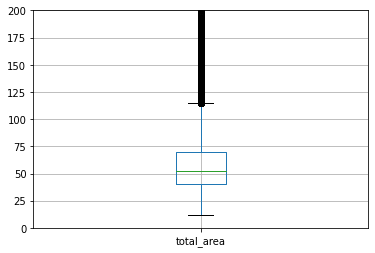

In [29]:
import matplotlib.pyplot as plt
plt.ylim(0,200)
data.boxplot(column=['total_area'])

In [30]:
data['total_area'].describe()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

In [31]:
# Удалим квартиры, для которых общая площадь составляет больше 300 кв. м.
data_total_area = data.query('total_area < 300')
info_lost_total_area = (data['total_area'].count() - data.query('total_area < 300')['total_area'].count())/data['total_area'].count() * 100

print(f"Потеря информации за счет удаления квартир " \
        f"со значением общей площади более 300 м составила {info_lost_total_area:.2f}%")

Потеря информации за счет удаления квартир со значением общей площади более 300 м составила 0.27%


In [32]:
data['last_price'].describe()

count    2.361300e+04
mean     6.540555e+06
std      1.090172e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<AxesSubplot:>

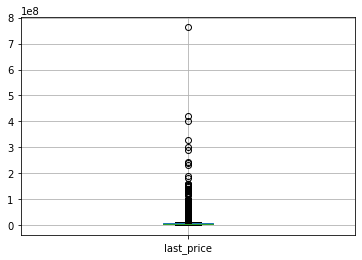

In [33]:
data.boxplot(column=['last_price'])

<AxesSubplot:>

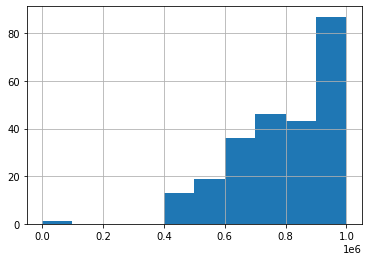

In [34]:
data['last_price'].hist(range=(0,1000000))

In [35]:
# Аномально низкое значение стоимости квартиры = 12190 р 
# удалим эту строку + избавляемся от слишком дорогих квартир
data_last_price = data.query('last_price != 12190 and last_price < 300000000')

In [36]:
data['living_area'].describe()

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

<AxesSubplot:>

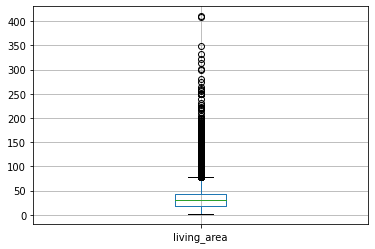

In [37]:
data.boxplot(column='living_area')

In [38]:
# Удалим квартиры, для которых жилая площадь составляет и больше 300 кв. м.
data_living_area = data.query('living_area < 300')
info_lost_living_area = (data['living_area'].count() - data_living_area['living_area'].count())/data['living_area'].count() * 100

print(f"Потеря информации за счет удаления квартир " \
        f"со значением жилой площади более 300 м составила {info_lost_living_area:.2f}%")

Потеря информации за счет удаления квартир со значением жилой площади более 300 м составила 0.04%


In [39]:
data['kitchen_area'].describe()

count    21382.000000
mean        10.564128
std          5.904316
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:>

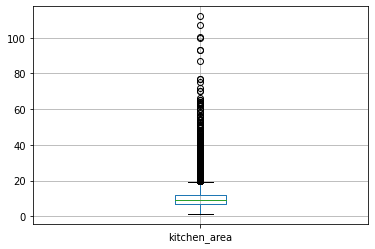

In [40]:
data.boxplot(column='kitchen_area')

In [41]:
data_kitchen_area = data.query('kitchen_area < 70')
info_lost_kitchen_area = (data['kitchen_area'].count() - data_kitchen_area['kitchen_area'].count())/data['kitchen_area'].count() * 100

print(f"Потеря информации за счет удаления квартир " \
        f"со значением площади кухни более 7 м и менее 70 м составила {info_lost_kitchen_area:.2f}%")

Потеря информации за счет удаления квартир со значением площади кухни более 7 м и менее 70 м составила 0.06%


<AxesSubplot:>

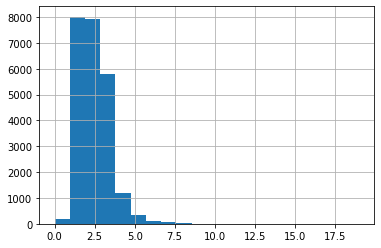

In [42]:
data['rooms'].hist(bins=20)

<AxesSubplot:>

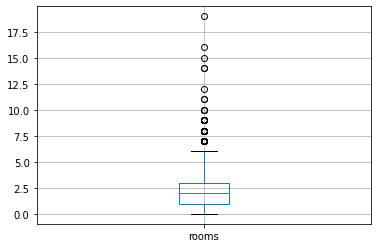

In [43]:
data.boxplot(column='rooms')

In [44]:
# Отбросим те объявления, где в квартире больше 7 комнат
data_rooms = data.query('rooms < 7')
info_lost_rooms = (data['rooms'].count() - data_kitchen_area['rooms'].count())/data['rooms'].count() * 100

print(f"Потеря информации за счет удаления квартир " \
        f"с числом комнат больше 7 составила {info_lost_kitchen_area:.2f}%")

Потеря информации за счет удаления квартир с числом комнат больше 7 составила 0.06%


In [45]:
multiline_query = '''
                ((ceiling_height > 2.4) and (ceiling_height < 6)) and \
                total_area < 300 and \
                (last_price != 12190 and last_price < 300000000) and \
                living_area < 300 and \
                kitchen_area < 70 and \
                rooms < 7'''
       

data_filter = data.query(multiline_query)                  
#display(data_filtered.head(10))

In [46]:
# Заполним пропуски в столбцах ceiling_height, living_area и kitchen_area медианными значениями, рассчитанными
# по отфильтрованному датафрейму

data['ceiling_height'] = data['ceiling_height'].fillna(data_filter['ceiling_height'].median())
data['living_area'] = data['living_area'].fillna(data_filter['living_area'].median())
data['kitchen_area'] = data['kitchen_area'].fillna(data_filter['kitchen_area'].median())

In [47]:
data.isna().sum().sort_values(ascending=False)

parks_nearest           15568
ponds_nearest           14552
airports_nearest         5532
cityCenters_nearest      5509
days_exposition          3172
locality_name              48
last_price                  0
ponds_around3000            0
parks_around3000            0
balcony                     0
kitchen_area                0
total_images                0
studio                      0
is_apartment                0
floor                       0
living_area                 0
floors_total                0
ceiling_height              0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        23613 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           23613 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          23613 non-null  float64       
 13  balcony         

In [49]:
data_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20782 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20782 non-null  int64         
 1   last_price            20782 non-null  float64       
 2   total_area            20782 non-null  float64       
 3   first_day_exposition  20782 non-null  datetime64[ns]
 4   rooms                 20782 non-null  int64         
 5   ceiling_height        20782 non-null  float64       
 6   floors_total          20782 non-null  int64         
 7   living_area           20782 non-null  float64       
 8   floor                 20782 non-null  int64         
 9   is_apartment          20782 non-null  bool          
 10  studio                20782 non-null  bool          
 11  open_plan             20782 non-null  bool          
 12  kitchen_area          20782 non-null  float64       
 13  balcony         

In [50]:
# Посмотрим, какой процент наблюдений мы потеряем при использовании фильтров

info_lost = (data['total_images'].count() - data_filter['total_images'].count())/data['total_images'].count() * 100

print(f"Потеря информации за счет удаления квартир " \
        f"с редкими и выбивающимися значениями составила {info_lost:.2f}%")

# Обычно удаляют не более 5-10% данных

Потеря информации за счет удаления квартир с редкими и выбивающимися значениями составила 11.99%


> Особенности в данных:
1. В столбце ceiling_height была указана высота потолков больше 10 м. Поэтому такие значения было решено поделить на 10 , т.к. средняя высота потолка - около 3 м.
2. В столбце last_price было замечено аномально низкое значение стоимости квартиры = 12190 р
3. Для некоторых квартир площадь кухни была больше, чем жилая площадь

### Посчитайте и добавьте в таблицу новые столбцы

In [51]:
# Добавим столбец с ценой одного квадратного метра
data_filtered = data_filter.copy(deep=True) # создадим копию датафрейма
data_filtered['price_sq_meter'] = data_filter['last_price']/data_filter['total_area']

In [52]:
# Добавим день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data_filtered['weekday'] = data_filter['first_day_exposition'].dt.dayofweek

In [53]:
# Добавим месяц и год публикации объявления 
data_filtered['month'] = pd.DatetimeIndex(data_filter['first_day_exposition']).month
data_filtered['year'] = pd.DatetimeIndex(data_filter['first_day_exposition']).year

In [54]:
# Добавим тип этажа квартиры (значения — «первый», «последний», «другой»)
# Создаю функцию по определению типа этажа
def func_floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'Первый'
    elif floor == floors_total:
        return 'Последний'
    else:
        return 'Другой'

In [55]:
data_filtered['floor_type'] = data_filter[['floor', 'floors_total']].apply(func_floor_type, axis=1)

In [56]:
# Добавим расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)
data_filtered['cityCenters_nearest_km'] = (data_filter['cityCenters_nearest']/1000).round()

In [57]:
display(data_filtered.head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_meter,weekday,month,year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,Другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,Первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,Другой,14.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,Другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.40,5,False,False,False,9.10,0,поселок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0,95065.789474,0,9,2018,Другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26,10.60,6,False,False,False,14.40,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,Другой,19.0
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.81,0,поселок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0,87454.764777,2,5,2018,Другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,Другой,15.0
10,5,5050000.0,39.60,2017-11-16,1,2.67,12,20.30,3,False,False,False,8.50,0,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525,3,11,2017,Другой,14.0
11,9,3300000.0,44.00,2018-08-27,2,2.65,5,31.00,4,False,False,False,6.00,1,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000.000000,0,8,2018,Другой,52.0


### Проведите исследовательский анализ данных

#### Изучите следующие параметры объектов:
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* этаж квартиры;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего аэропорта;
* расстояние до ближайшего парка;
* день и месяц публикации объявления.
<br/>
<br/>
Постройте отдельные гистограммы для каждого из этих параметров.

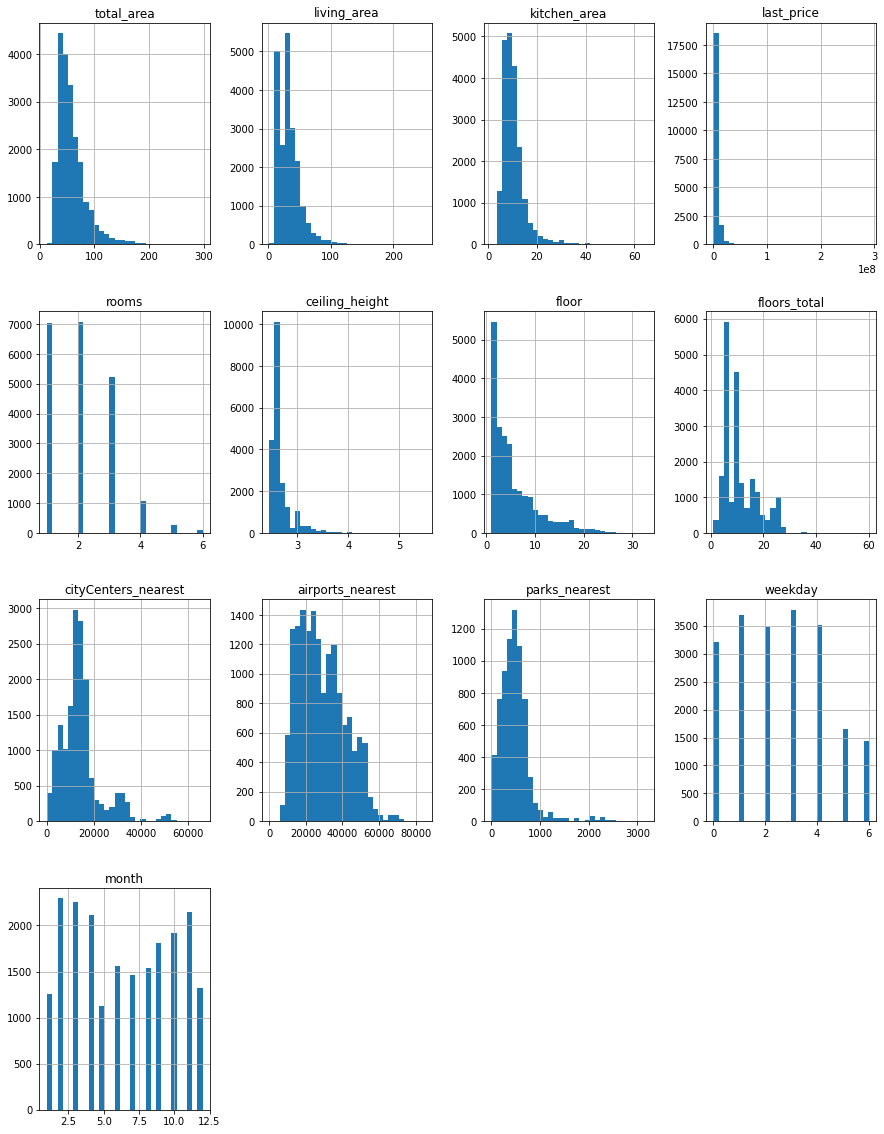

In [58]:
objects = [
    'total_area', 'living_area', 'kitchen_area', 'last_price', 
    'rooms', 'ceiling_height', 'floor', 'floor_type', 'floors_total', 
    'cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'weekday', 
    'month'
]
data_filtered[objects].hist(bins=30, figsize=(15,20))
plt.show()

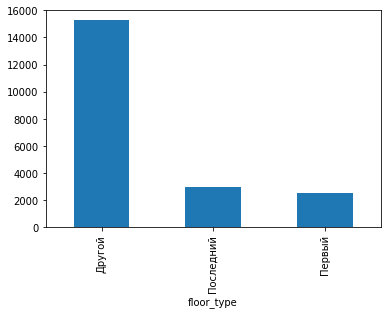

In [59]:
data_filtered.groupby('floor_type')['floor_type'].count().sort_values(ascending=False).plot(kind='bar')
plt.show()

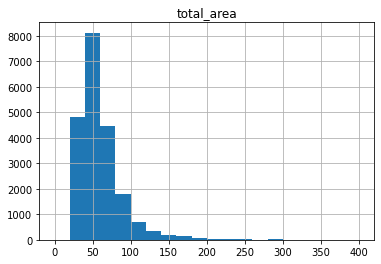

In [60]:
data_filtered['total_area'].hist(range=(0,400), bins=20)
plt.title('total_area')
plt.show()

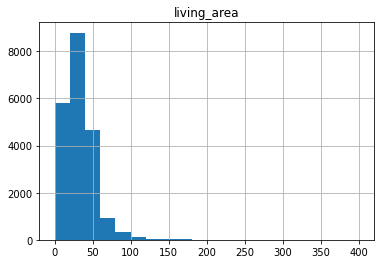

In [61]:
data_filtered['living_area'].hist(range=(0,400), bins=20)
plt.title('living_area')
plt.show()

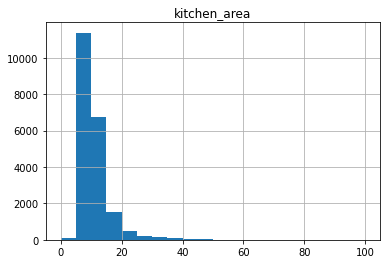

In [62]:
data_filtered['kitchen_area'].hist(range=(0,100), bins=20)
plt.title('kitchen_area')
plt.show()

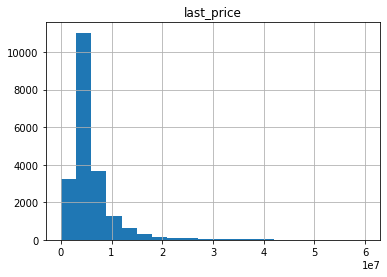

In [63]:
data_filtered['last_price'].hist(range=(0,60000000), bins=20)
plt.title('last_price')
plt.show()

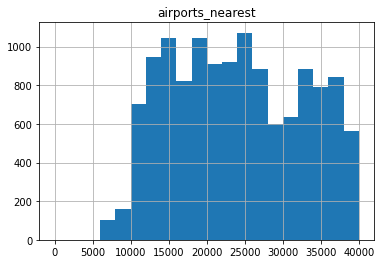

In [64]:
data_filtered['airports_nearest'].hist(range=(0,40000), bins=20)
plt.title('airports_nearest')
plt.show()

> Наблюдения:
1. Большинство квартир имеет общую площадь от 40 до 60 м2, а жилая площадь составляет от 20 до 40 м2 
2. У основной части квартир размер кухни 5-10 м2 
3. Цена большей части квартир не превышает 10 миллионов
4. Большинство квартир имеет 1-3 комнаты и высоту потолка 2,7 м
5. Основная часть квартир размещается в 5- и 10-этажных домах
6. Расстояние до аэропорт для болшей части квартир составляет 10-40 км
7. Основная часть квартир находится ~ в 15 км от центра города
8. Для большинства квартир ближайший парк находится в 500 м
9. Основная часть объявлений о продаже была размещена в будние дни
10. Самые активные месяцы с точки зрения размещения объявлений: февраль, март, апрель, ноябрь, а меньше всего - в мае
11. Большая часть квартир размещается не на последнем и первом этажах


#### Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.

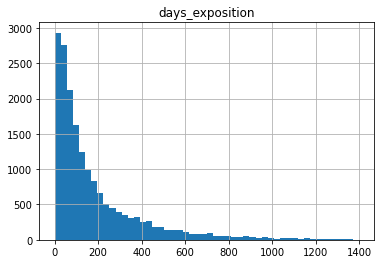

In [65]:
# Построим гистрограмму для столбца days_exposition
data_filtered['days_exposition'].hist(bins=50, range=(0,1400))
plt.title('days_exposition')
plt.show()

In [66]:
# Рассчитаем среднее и медиану
data_filtered['days_exposition'].describe()

count    17932.000000
mean       185.323333
std        221.650270
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

Обычно квартира продается примерно через 100 дней с момента публикации объявления (об этом нам говорит гистограмма, медианное значение составляет 95 дней). 
<br/>
Быстрыми можно считать продажи, реализованные менее, чем через 60 дней с момента публикации объявления. 
<br/>
Необычно долгими считаются продажи, которые длятся больше 2 лет. Такая длительность продажи может быть связана с разными факторами (очень высокая цена за жилье, плохое состояние, неудобное расположение и пр.)

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта? 

Изучите, зависит ли цена от: 

* общей площади;
* жилой площади;
* площади кухни;
* количества комнат;
* этажа, на котором расположена квартира (первый, последний, другой);
* даты размещения (день недели, месяц, год).


Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

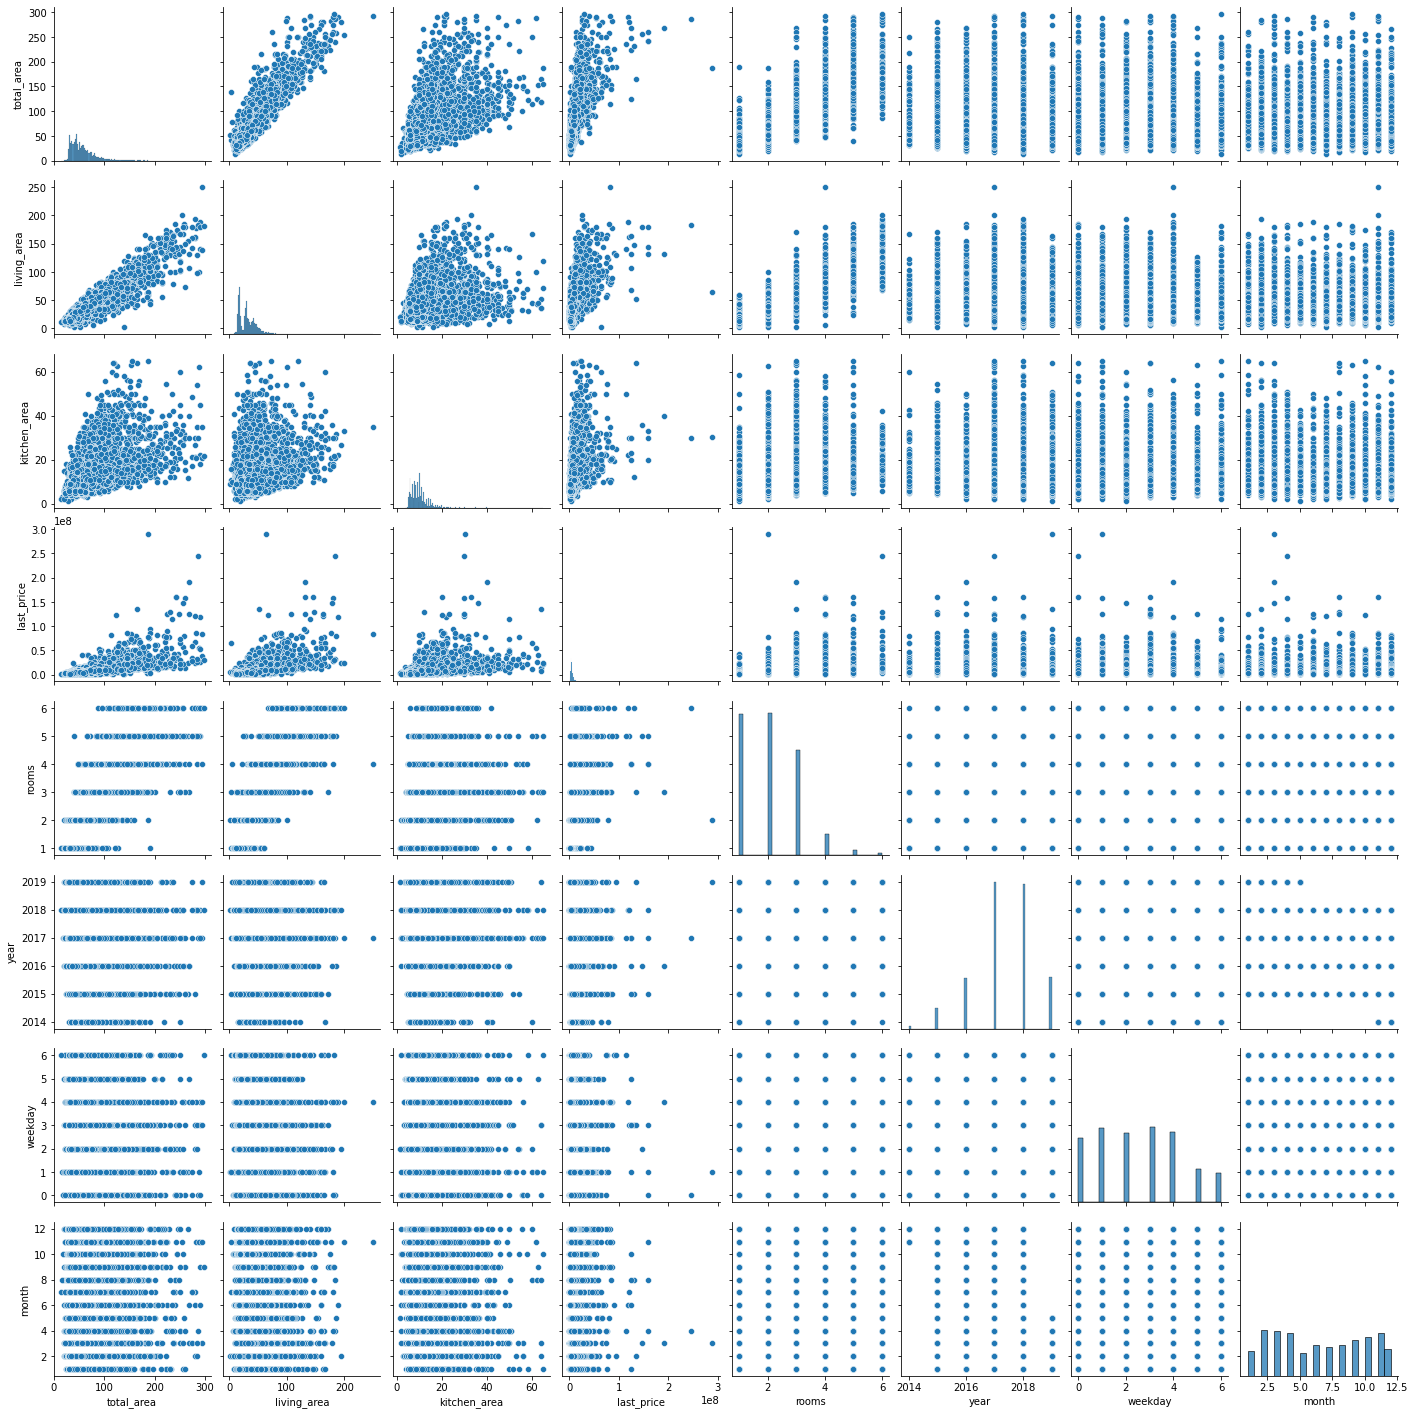

In [67]:
import seaborn as sns # подключаем библиотеку Seaborn
parameters = [
    'total_area', 'living_area', 'kitchen_area', 'last_price', 
    'rooms', 'floor_type', 'year', 'weekday', 'month'    
]
sns.pairplot(data_filtered[parameters]) # строим попарные зависимости для всех параметров
plt.show()

> Видно, что для колонок 'total_area', 'living_area', 'kitchen_area' видна прямая зависимость цены (при увеличении площади  цена растет)

In [68]:
# Прологарифмируем значения столбцов 'total_area', 'living_area', 'kitchen_area' и 'last_price', чтобы посмотреть распределение

import numpy as np # подключаем библиотеку numpy 

# 'total_area', 'living_area', 'kitchen_area'
data_filtered['log_last_price'] = np.log(data_filtered.last_price)
data_filtered['log_total_area'] = np.log(data_filtered.total_area)
data_filtered['log_living_area'] = np.log(data_filtered.living_area)
data_filtered['log_kitchen_area'] = np.log(data_filtered.kitchen_area)

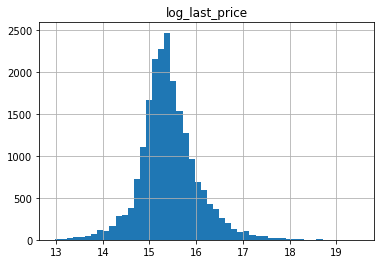

In [69]:
data_filtered['log_last_price'].hist(bins=50) # строим гистограмму для столбца last_price, чтобы оценить распределение
plt.title('log_last_price')
plt.show()

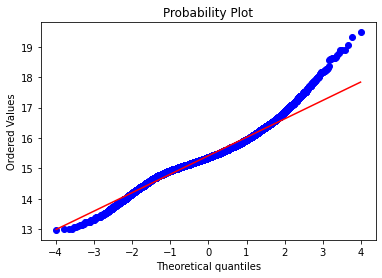

In [70]:
import scipy.stats as stats # подключаем библиотеку scipy.stats 
stats.probplot(data_filtered['log_last_price'], dist="norm", plot=plt) # смотрим, как много у нас выбивающихся значений
plt.show()

> Столбец last_price имеет нормальное распределение

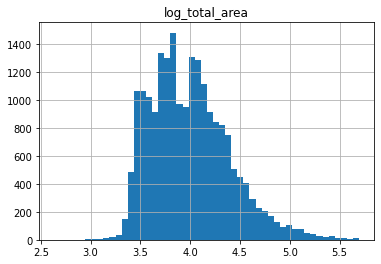

In [71]:
data_filtered['log_total_area'].hist(bins=50)
plt.title('log_total_area')
plt.show()

<AxesSubplot:xlabel='log_total_area'>

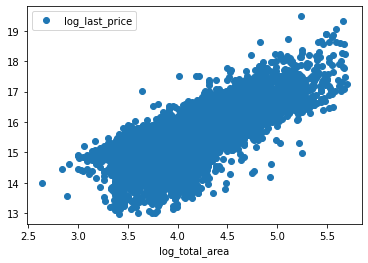

In [72]:
data_filtered.plot(x='log_total_area', y='log_last_price', style='o')

In [73]:
data_filtered['log_total_area'].corr(data_filtered['log_last_price'])

0.7548223934125251

> Видно, что существует корреляция между ценой квартиры и ее общей площадью: цена линейно зависит от площади квартиры

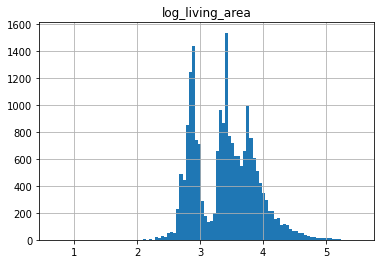

In [74]:
# Посмотрим, как цена квартиры зависит от жилой площади
data_filtered['log_living_area'].hist(bins=100)
plt.title('log_living_area')
plt.show()

> Квартиры можно разбить на подгруппы, поскольку на графике распределения наблюдается 3 "горба"

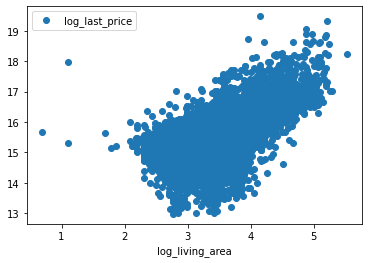

In [75]:
data_filtered.plot(x='log_living_area', y='log_last_price', style='o')
plt.show()

In [76]:
# Рассчитаем коэффициент корреляции для зависимости цены от жилой площади без разбивки на подгруппы

data_filtered['log_living_area'].corr(data_filtered['log_last_price'])

0.6230132707273899

In [77]:
#  Создадим функцию, которая позволит разделить данные на 3 группы по размеру жилой площади

def func_living_area_group(row):
    log_living_area = row['log_living_area']
    if log_living_area < 3.1:
        return 'Менее 22 м2'
    elif 3.1 <= log_living_area <= 3.6:
        return 'От 22 до 36 м2'
    elif log_living_area > 3.6:
        return 'Более 36 м2'    

In [78]:
data_filtered['living_area_group'] = data_filtered.apply(func_living_area_group, axis=1)

living_area_group
Более 36 м2       AxesSubplot(0.125,0.125;0.775x0.755)
Менее 22 м2       AxesSubplot(0.125,0.125;0.775x0.755)
От 22 до 36 м2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

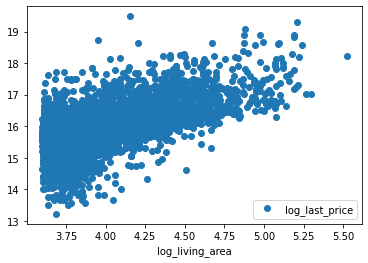

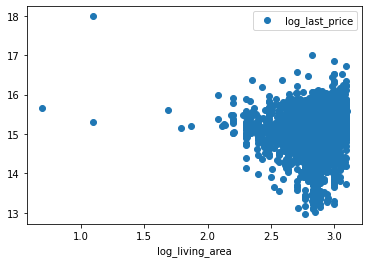

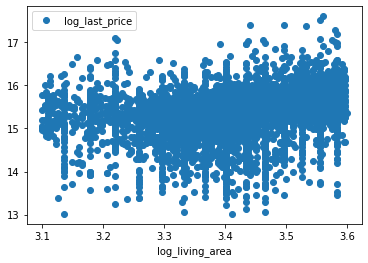

In [79]:
data_filtered.groupby('living_area_group').plot(x='log_living_area', y='log_last_price', style='o')


In [80]:
# Рассчитаем коэффициент корреляции для зависимости цены от жилой площади для подгруппы "Менее 22 м2"

# количество квартир в группе
print(data_filtered.query('living_area_group == "Менее 22 м2"')['living_area_group'].count())

a = data_filtered.query('living_area_group == "Менее 22 м2"')
a['log_living_area'].corr(data_filtered['log_last_price'])

6837


0.08165313987586528

In [81]:
# Рассчитаем коэффициент корреляции для зависимости цены от жилой площади для подгруппы "От 22 до 36 м2"

# количество квартир в группе
print(data_filtered.query('living_area_group == "От 22 до 36 м2"')['living_area_group'].count())

b = data_filtered.query('living_area_group == "От 22 до 36 м2"')
b['log_living_area'].corr(data_filtered['log_last_price'])

6666


0.2511526467993458

In [82]:
# Рассчитаем коэффициент корреляции для зависимости цены от жилой площади для подгруппы "Более 36 м2"

# количество квартир в группе
print(data_filtered.query('living_area_group == "Более 36 м2"')['living_area_group'].count())

c = data_filtered.query('living_area_group == "Более 36 м2"')
c['log_living_area'].corr(data_filtered['log_last_price'])

7279


0.6324679362195168

> После группировки данных по значению жилой площади и построения графиков зависимости цены квартиры от жилой площади мы не можем однозначно сказать, как увеличение жилой площади сказывается на стоимости квартиры.
<br/>
Для квартир с площадью менее 36 м2 зависимость цены от жилой площади практически не прослеживается (коэффициент корреляции 0.2), в то время как для группы квартир с площадью более 36 м2 коэффициент корреляции составил 0.65, также как и для выборки в целом(без деления на группы). 
<br/>
Таким образом, можно сделать вывод, что для квартир с маленькой площадью более сильное влияние на цену оказывают другие факторы (удаленность от центра, наличие парков поблизости и пр.), нежели ее жилая площадь.

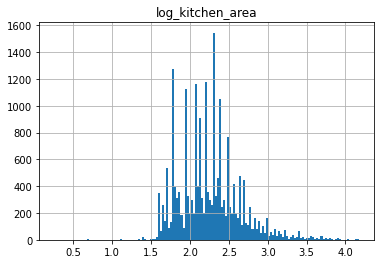

In [83]:
# Посмотрим, как площадь кухни влияет на цену квартиры

data_filtered['log_kitchen_area'].hist(bins=150)
plt.title('log_kitchen_area')
plt.show()

In [84]:
#  Создадим функцию, которая позволит разделить данные на 3 группы по размеру кухни

def func_kitchen_area_group(row):
    log_kitchen_area = row['log_kitchen_area']
    if log_kitchen_area < 1.6:
        return 'Менее 4 м2'
    elif 1.6 <= log_kitchen_area < 1.9:
        return 'От 4 до 6 м2'
    elif 1.9 <= log_kitchen_area <= 2.1:
        return 'От 6 до 8 м2'
    elif log_kitchen_area > 2.1:
        return 'Более 8 м2'    

In [85]:
data_filtered['kitchen_area_group'] = data_filtered.apply(func_kitchen_area_group, axis=1)

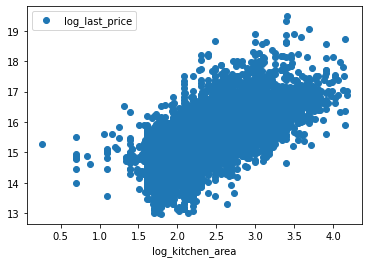

In [86]:
data_filtered.plot(x='log_kitchen_area', y='log_last_price', style='o')
plt.show()

In [87]:
# Рассчитаем коэффициент корреляции для зависимости цены от площади кухни без разбивки на подгруппы

data_filtered['log_kitchen_area'].corr(data_filtered['log_last_price'])

0.6082221026373638

kitchen_area_group
Более 8 м2      AxesSubplot(0.125,0.125;0.775x0.755)
Менее 4 м2      AxesSubplot(0.125,0.125;0.775x0.755)
От 4 до 6 м2    AxesSubplot(0.125,0.125;0.775x0.755)
От 6 до 8 м2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

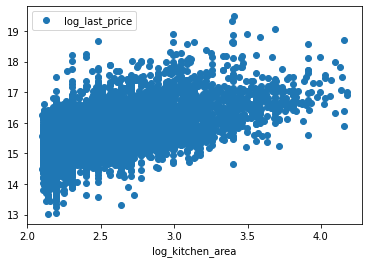

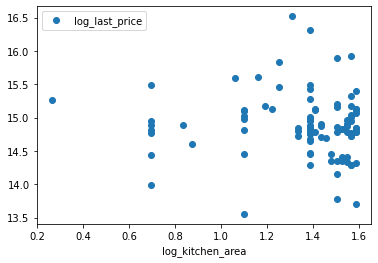

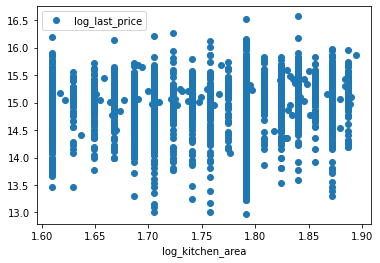

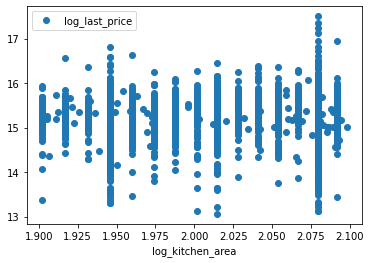

In [88]:
data_filtered.groupby('kitchen_area_group').plot(x='log_kitchen_area', y='log_last_price', style='o')

In [89]:
# Рассчитаем коэффициент корреляции для зависимости цены от площади кухни для подгруппы "Более 8 м2"

# количество квартир в группе
print(data_filtered.query('kitchen_area_group == "Более 8 м2"')['kitchen_area_group'].count())

d = data_filtered.query('kitchen_area_group == "Более 8 м2"')
d['log_kitchen_area'].corr(data_filtered['log_last_price'])

13055


0.5712675105315062

> Вывод: для квартир с большой площадью площадь кухни имеет влияние на цену (чем больше кухня, тем выше стоимость); для маленьких квартир зависимости не наблюдается

In [90]:
# Изучим, как количество комнат в квартире влияет на ее стоимость

pivot_rooms = data_filtered.pivot_table(index='rooms', values='log_last_price', aggfunc='median').reset_index()

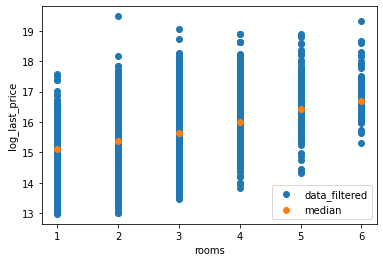

In [91]:
plt.scatter(data_filtered['rooms'], data_filtered['log_last_price'])
plt.scatter(pivot_rooms['rooms'], pivot_rooms['log_last_price'])
plt.legend(["data_filtered", "median"])
plt.xlabel("rooms")
plt.ylabel("log_last_price")
plt.show()

In [92]:
# Рассчитаем коэффициент корреляции для зависимости цены от количества комнат 

data_filtered['rooms'].corr(data_filtered['log_last_price'])

0.5205038971156782

> Вывод: для квартир, количество комнат в которых до 7 включительно, наблюдается прямая корреляция с ценой квартиры. 

In [93]:
data_filtered.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_sq_meter', 'weekday',
       'month', 'year', 'floor_type', 'cityCenters_nearest_km',
       'log_last_price', 'log_total_area', 'log_living_area',
       'log_kitchen_area', 'living_area_group', 'kitchen_area_group'],
      dtype='object')

In [94]:
# Изучим, как этаж (его категория) влияет на стоимость квартиры
import seaborn as sns
pivot_table_floor_type = data_filtered.pivot_table(index='floor_type', values='last_price', aggfunc='mean')
pivot_table_floor_type = pivot_table_floor_type.reset_index()
pivot_table_floor_type

,floor_type,last_price
0,Другой,6.484225e+06
1,Первый,4.733557e+06
2,Последний,6.241993e+06


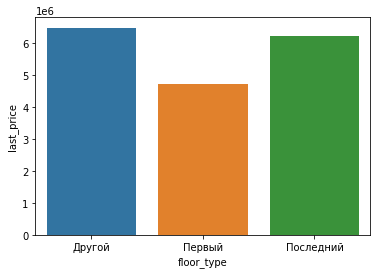

In [95]:
import seaborn as sns
sns.barplot(x=pivot_table_floor_type['floor_type'], y=pivot_table_floor_type['last_price'])
plt.show()

> Вывод: квартиры на первом этаже имеют стоимость ниже, чем квартиры на других этажах. Таким образом, этаж оказывает влияние на финальную стоимость квартиры

In [96]:
data_filtered['floor'].corr(data_filtered['log_last_price'])

0.13269126915421559

In [97]:
pivot_floor = data_filtered.pivot_table(index='floor', values='log_last_price', aggfunc='median').reset_index()

Text(0, 0.5, 'log_last_price')

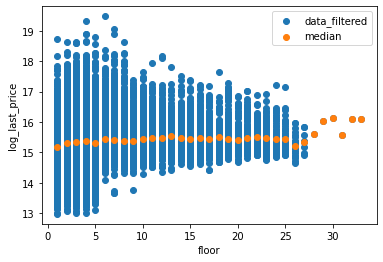

In [98]:
plt.scatter(data_filtered['floor'], data_filtered['log_last_price'])
plt.scatter(pivot_floor['floor'], pivot_floor['log_last_price'])
plt.legend(["data_filtered", "median"])
plt.xlabel("floor")
plt.ylabel("log_last_price")

> Вывод: четкой зависимости стоимости квартиры от этажа не наблюдается

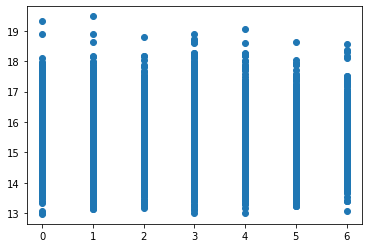

In [99]:
# Проанализируем, есть ли зависимость цены квартиры от дня

plt.scatter(data_filtered['weekday'], data_filtered['log_last_price'])

In [100]:
pivot_weekday = data_filtered.pivot_table(index='weekday', values='log_last_price', aggfunc='median').reset_index()

Text(0, 0.5, 'log_last_price')

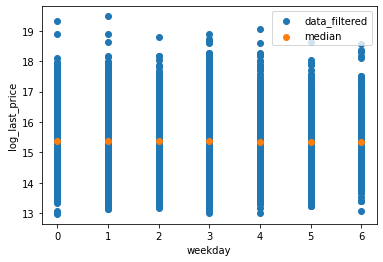

In [101]:
plt.scatter(data_filtered['weekday'], data_filtered['log_last_price'])
plt.scatter(pivot_weekday['weekday'], pivot_weekday['log_last_price'])
plt.legend(["data_filtered", "median"])
plt.xlabel("weekday")
plt.ylabel("log_last_price")

> Вывод: в зависимость цены квартиры от дня недели заложены зависимости от года публикации объявления, от месяца публикации. В понедельник в марте 2014 года квартира могла стоить дороже (или дешевле), чем в понедельник в ноябре 2019.

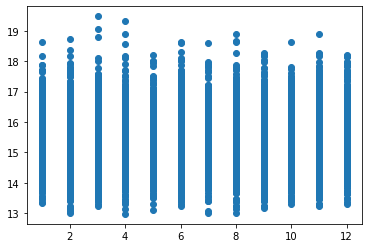

In [102]:
# Проанализируем, есть ли зависимость цены квартиры от месяца

plt.scatter(data_filtered['month'], data_filtered['log_last_price'])

In [103]:
pivot_month = data_filtered.pivot_table(index='month', values='log_last_price', aggfunc='median').reset_index()

Text(0, 0.5, 'log_last_price')

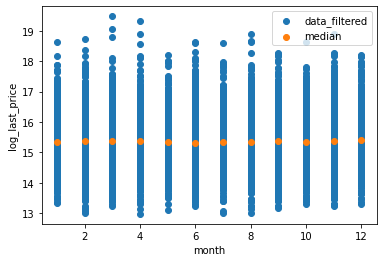

In [104]:
plt.scatter(data_filtered['month'], data_filtered['log_last_price'])
plt.scatter(pivot_month['month'], pivot_month['log_last_price'])
plt.legend(["data_filtered", "median"])
plt.xlabel("month")
plt.ylabel("log_last_price")

> Вывод: зависимость цены от месяца показывает ежегодную тенденцию и месячные колебания

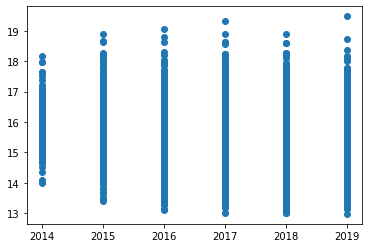

In [105]:
# Проанализируем, есть ли зависимость цены квартиры от года публикации объявления
plt.scatter(data_filtered['year'], data_filtered['log_last_price'])

In [106]:
# Сделаем сводную таблицу по годам публикации объявления
pivot_year = data_filtered.pivot_table(index='year', values='log_last_price', aggfunc='median')
pivot_year = pivot_year.reset_index()

Text(0, 0.5, 'log_last_price')

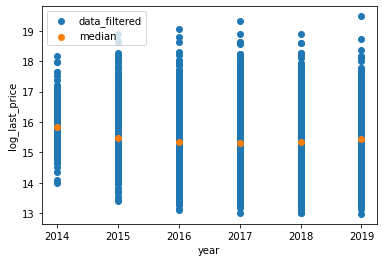

In [107]:
plt.scatter(data_filtered['year'], data_filtered['log_last_price'])
plt.scatter(pivot_year['year'], pivot_year['log_last_price'])
plt.legend(["data_filtered", "median"])
plt.xlabel("year")
plt.ylabel("log_last_price")

In [108]:
data_filtered['locality_name'].value_counts().sort_values(ascending=False).head(10)

Санкт-Петербург      13904
поселок Мурино         430
поселок Шушары         392
Всеволожск             356
Пушкин                 333
Колпино                320
Гатчина                290
поселок Парголово      288
деревня Кудрово        226
Петергоф               190
Name: locality_name, dtype: int64

In [109]:
median_price_Spb = (
(
    data_filtered
                .query('locality_name == "Санкт-Петербург"')
                .groupby('year')['log_last_price']
                .mean()
                .sort_values(ascending=False)
)
)

In [110]:
median_price_Spb.reset_index()

,year,log_last_price
0,2014,16.214943
1,2015,15.777436
2,2019,15.683187
3,2016,15.640728
4,2018,15.621184
5,2017,15.601397


In [111]:
median_price_Pushkin = (
(
    data_filtered
                .query('locality_name == "Пушкин"')
                .groupby('year')['log_last_price']
                .mean()
                .sort_values(ascending=False)
)
)

In [112]:
median_price_Pushkin.reset_index()

,year,log_last_price
0,2014,15.809966
1,2015,15.784629
2,2016,15.550490
3,2018,15.512795
4,2017,15.499716
5,2019,15.469234


> До начала непосредственного анализа зависимости цены квартиры от года публикации объявления, я была уверена, что недвижимость в Санкт-Петербурге и крупных городах в Ленинградской области с годами становится дороже. Однако, данные показали что это не так (если смотреть на среднее значение стоимости)

#### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [113]:
data_filtered.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_sq_meter', 'weekday',
       'month', 'year', 'floor_type', 'cityCenters_nearest_km',
       'log_last_price', 'log_total_area', 'log_living_area',
       'log_kitchen_area', 'living_area_group', 'kitchen_area_group'],
      dtype='object')

In [114]:
data_filtered_top_10 = data_filtered['locality_name'].value_counts().sort_values(ascending=False).head(10)

In [115]:
# Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
mean_data_filtered_top_10 = (
(
    data_filtered
                .query('locality_name in @data_filtered_top_10.index')
                .groupby('locality_name')['price_sq_meter']
                .mean()
                .sort_values(ascending=False)
)
)

In [116]:
mean_data_filtered_top_1 = mean_data_filtered_top_10.reset_index()

In [117]:
mean_data_filtered_top_1

,locality_name,price_sq_meter
0,Санкт-Петербург,113250.734706
1,Пушкин,103329.033247
2,деревня Кудрово,92248.477506
3,поселок Парголово,90756.003417
4,поселок Мурино,85366.547426
5,Петергоф,83754.204102
6,поселок Шушары,78393.702167
7,Колпино,75149.348401
8,Всеволожск,69102.517240
9,Гатчина,68635.620745


<AxesSubplot:xlabel='price_sq_meter', ylabel='locality_name'>

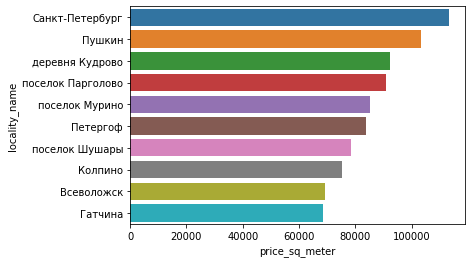

In [118]:
sns.barplot(x=mean_data_filtered_top_1['price_sq_meter'], y=mean_data_filtered_top_1['locality_name'])

In [119]:
print(mean_data_filtered_top_10.index[0])
print(mean_data_filtered_top_10.index[-1])

Санкт-Петербург
Гатчина


> Самая низкая цена за квадратный метр в Гатчине, самая высокая - в Санкт-Петербурге

#### Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [120]:
data_filtered_spb = data_filtered.query('locality_name == "Санкт-Петербург"').groupby('cityCenters_nearest_km')['price_sq_meter'].mean()

In [121]:
data_filtered_spb = data_filtered_spb.reset_index()

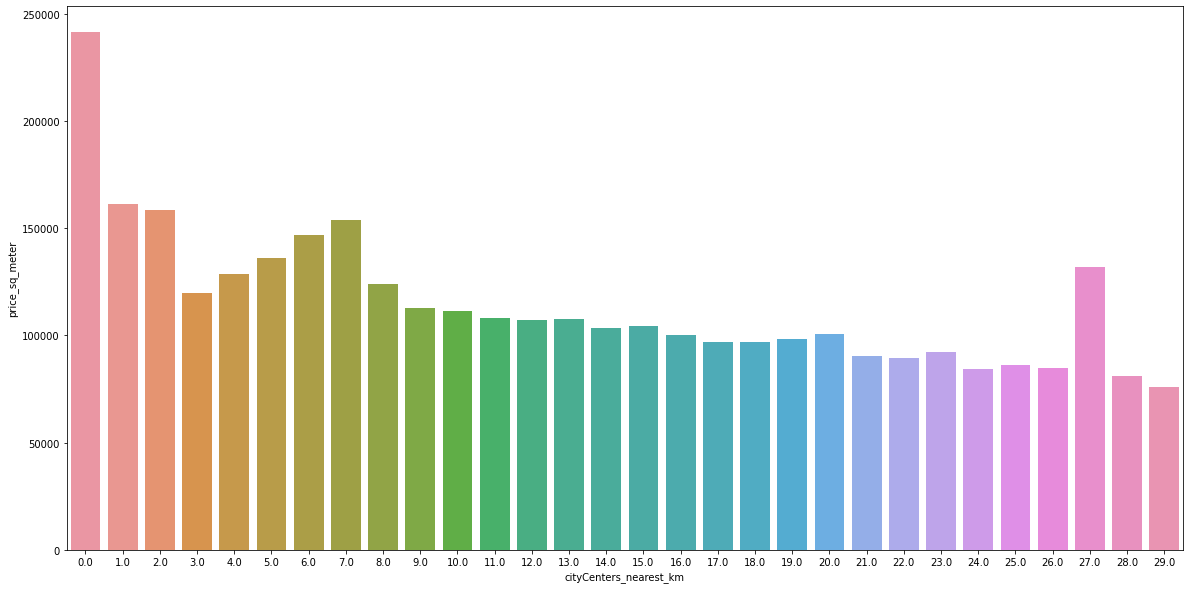

In [122]:
sns.barplot(x=data_filtered_spb['cityCenters_nearest_km'], y=data_filtered_spb['price_sq_meter'])
plt.gcf().set_size_inches(20,10)

In [123]:
# Найдем стоимость километра 
# Вычитаем из средней цены в центре среднюю цену на отдалении
data_filtered_spb['price_difference'] = (data_filtered_spb['price_sq_meter'] - data_filtered_spb['price_sq_meter'][0]).abs()

In [124]:
# делим на удаленность в км
data_filtered_spb['price_per_km'] = data_filtered_spb['price_difference']/data_filtered_spb['cityCenters_nearest_km']

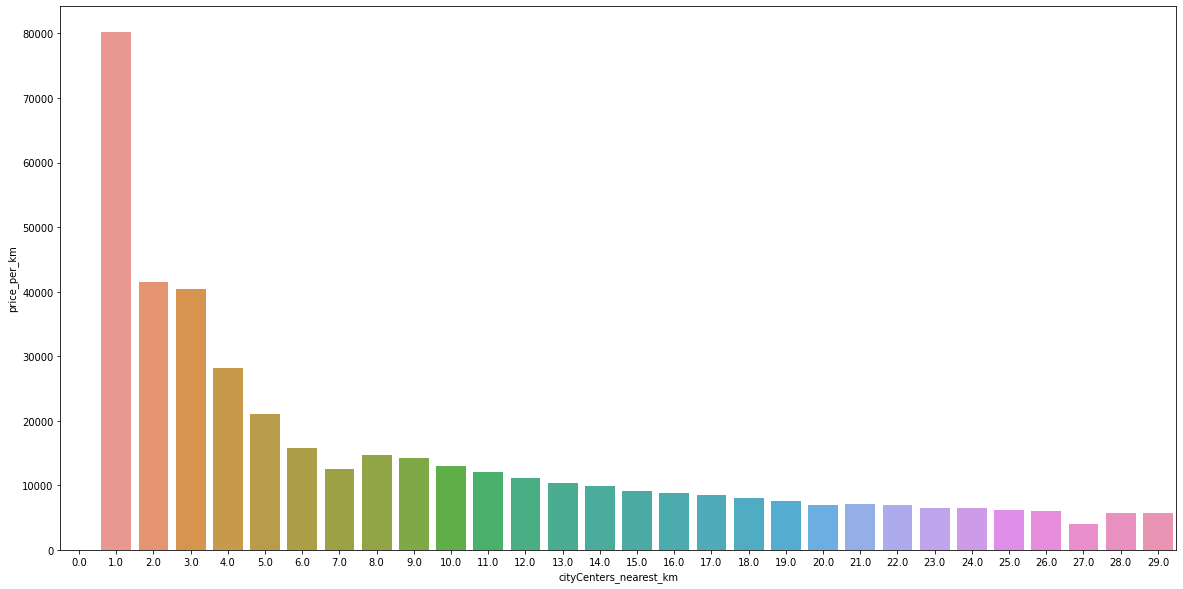

In [125]:
sns.barplot(x=data_filtered_spb['cityCenters_nearest_km'], y=data_filtered_spb['price_per_km'])
plt.gcf().set_size_inches(20,10)

> Вывод: с увеличением расстояния от центра города цена на квартиры падает. Самая высокая стоимость наблюдается для квартир в центре Санкт-Петербурга.

### Общий вывод

В ходе выполнения проекта:
1. Найдены и изучены пропущенные значения в данных; там, где это возможно, пропущенные значения были заполнены 
2. Рассмотрены типы исходных данных; для некоторых столбцов тип данных был изменен
3. Удалены неявные дупликаты в названиях населенных пунктов
4. Найдены и устранены редкие и выбивающиеся значения 
5. Проведен анализ данных и выявлены следующие зависимости, которые наблюдаются на рынке недвижимости:
    * Обычно квартира продается примерно через 100 дней с момента публикации объявления (об этом нам говорит гистограмма, медианное значение составляет 95 дней)
    * Существует прямая зависимость общей площади квартиры и ее цены на рынке: чем больше площадь, тем выше цена.
    * Для квартир с маленькой площадью более сильное влияние на цену оказывает не жилая площадь, а другие факторы (удаленность от центра, наличие парков поблизости и пр.), также в квартирах с большой площадью площадь кухни имеет влияние на стомость (чем больше кухня, тем выше цена)
    * Для квартир, количество комнат в которых до 7 включительно, наблюдается прямая корреляция с ценой квартиры
    * Квартиры, располагающиеся на первом этаже, имеют более низкую стоимость, по сравнению с квартирами на других этажах
    * Самая высокая средняя цена за кв. м. была отмечена в Санкт-Петербурге - 113 251 рублей/ кв.м
    * Если город является крупным (напр., Санкт-Петербург), то с увеличением расстояния от центра города цена на квартиры падает. 